In [8]:
import pandas as pd
import numpy as np
from convokit import Corpus, download
import matplotlib.pyplot as plt
import ssl
import random
import re
# Disable SSL verification - because it is annoying
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
awry_corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus")) #contains personal attacks
winning_corpus = Corpus(filename=download("winning-args-corpus"))

#convert the data into a dataframe
df_awry = awry_corpus.get_utterances_dataframe().reset_index()
df_winning = winning_corpus.get_utterances_dataframe().reset_index()

Dataset already exists at /Users/xehu/.convokit/downloads/conversations-gone-awry-cmv-corpus


# Corpus Information

## Conversations Gone Awry
- id: Reddit ID of the comment represented by the utterance
- speaker: the speaker who authored the utterance
- conversation_id: id of the first utterance in the conversation this utterance belongs to. Note that this differs from how ‘conversation_id’ is treated in ConvoKit’s general Reddit corpora: in those corpora a conversation is considered to start with a Reddit post utterance, whereas in this corpus a conversation is considered to start with a top-level reply to a post.
- reply_to: Reddit ID of the utterance to which this utterance replies to (None if the utterance represents a top-level comment, i.e., a reply to a post)
- timestamp: time of the utterance
- text: textual content of the utterance

## Winning Arguments
- id: index of the utterance (unique comment identification provided by Reddit)
- speaker: the unique id of the user who authored the utterance
- conversation_id: comment identifier of the original post in the thread that this comment was posted in
- reply_to: index of the utterance to which this utterance replies to (None if the utterance is not a reply)
- timestamp: utterance timestamp provided by Reddit API
- text: the full text (in string) of the comment
- success: an indicator taking the value of 1 if the comment was part of a successful argument thread (i.e. an argument thread that changed the OP’s mind), 0 if unsuccessful, and None if not part of either a successful or unsuccessful thread.
- pair_ids: every successful-unsuccessful argument pair originally compiled by the authors has a unique pair_id. However, it is important to note that not every argument is unique (i.e. a single negative argument within a conversation could have two opposing positive arguments, which necessitates two corresponding pair_ids. Therefore, pair_ids is a list).

Note: we should also add additional covariates, such as `meta.score`, provided they are shared across the datasets

Note: `p_4263` is the largest and final pair ID.

In [10]:
winning_conversation_threads = []

In [11]:
LARGEST_THREAD_ID = 4263

In [12]:
pair_threads = df_winning[df_winning["meta.pair_ids"].apply(len) > 0]

In [13]:
# Process the winning conversations into threads
for i in range(1, LARGEST_THREAD_ID): # these are the valid ID's we have
    # get threads
    pair_threads_for_index = pair_threads[pair_threads["meta.pair_ids"].apply(lambda x: "p_" + str(i) in x)]

    success_thread = pair_threads_for_index[pair_threads_for_index["meta.success"] == 0]
    unsuccessful_thread = pair_threads_for_index[pair_threads_for_index["meta.success"] == 1]

    # get OP (original post)
    OP_ID = pair_threads.iloc[0]["conversation_id"]
    op = df_winning[df_winning["id"]==OP_ID].copy()
    op["reply_to"] = "ORIGINAL_POST"

    # OP+success
    success_conv = pd.concat([op, success_thread])
    unsuccess_conv = pd.concat([op, unsuccessful_thread])

    # CONV_ID: an ID that we assign to designate a conversation that we're "splitting up here"
    success_conv["CONV_ID"] = str(i) + "_A"
    unsuccess_conv["CONV_ID"] = str(i) + "_B"

    winning_conversation_threads.append(success_conv)
    winning_conversation_threads.append(unsuccess_conv)

In [14]:
# Here are our winning conversations, grouped into the relevant threads
df_winning_conversations = pd.concat(winning_conversation_threads, axis=0)

In [15]:
# Make `CONV_ID` the ID to use in both dataframes
df_awry.rename(columns={"conversation_id": "CONV_ID"}, inplace=True)

In [16]:
# select shared set of columns for both
shared_cols = ["CONV_ID", "text", "speaker", "id", "timestamp", "meta.score", "reply_to"]
df_winning_conversations = df_winning_conversations[shared_cols]
df_awry = df_awry[shared_cols]

#### Break up long paragraphs

Sometimes, people write really long posts, which makes it hard to read and rate them. Let's set a rough rule for breaking them up.

If the message as a whole is longer than [threshold = 50] words...
- Identify any line breaks in the message, and use the line breaks to break apart message
- Group the chunks of messages with line breaks that have as close to 50 words as possible (there may be a bunch of extraneous line breaks between short comments, and we want to keep those together.)
- Save each 50-word chunk as a message on its own, with an `id` that is updated as: original `id + `_#` (where the number is the ith chunk of message)
- Retain all other column values (e.g., CONV_ID, speaker, timestamp, meta.score, reply_to)

In [17]:
def break_long_messages(df, threshold=200):
    new_rows = []
    
    for index, row in df.iterrows():
        text = row['text']
        message_id = row['id']
        
        """
        Check if: 
        - the message exceeds the threshold; 
        - there is a newline (\n) in the message we can split on
        - only do this if not OP
        """
        if len(text.split()) > threshold and '\n' in text and  row['reply_to'] is not "ORIGINAL_POST":
            chunks = [chunk.strip() for chunk in text.split('\n') if chunk.strip()]

            current_chunk_id = 1
            current_chunk = ""
            gt = False
            for chunk_num, chunk in enumerate(chunks):
                current_chunk += chunk
                
                # SEPARATELY HANDLE QUOTES: if an earlier chunk contains '&gt;' as a character, this is quoting another person.
                # We want the quote and the response to be grouped together as a single 'idea.'
                # Detect the "&gt;" character and save it separately if this is the case.  
                if("&gt;" in chunk):
                    current_chunk += "\n"
                    gt = True # toggle 'gt' on if this is the case
                elif(gt and not "&gt;" in chunk): # We found the response to the quote, so save it.
                    new_row = row.copy()
                    new_row['text'] = current_chunk.strip()
                    new_row['id'] = f"{message_id}_{current_chunk_id}"
                    new_rows.append(new_row)
                    current_chunk_id += 1
                    current_chunk = ""
                    gt = False
                elif len(re.sub('\n', '', current_chunk).split()) > threshold: # chunk is long enough; save directly
                    new_row = row.copy()
                    new_row['text'] = current_chunk.strip()
                    new_row['id'] = f"{message_id}_{current_chunk_id}"
                    new_rows.append(new_row)
                    current_chunk_id += 1
                    current_chunk = ""
                else: # not long enough; add next chunk
                    current_chunk += "\n"
            if(current_chunk != ""):
                # add the last chunk to the df, if it wasn't long enough
                new_row = row.copy()
                new_row['text'] = current_chunk.strip()
                new_row['id'] = f"{message_id}_{current_chunk_id}"
                new_rows.append(new_row)
        else:
            new_rows.append(row) # No changes necessary
    
    # Create a new DataFrame with the updated rows
    new_df = pd.DataFrame(new_rows, columns=df.columns)
    
    return new_df

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_16283/1521349723.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(text.split()) > threshold and '\n' in text and  row['reply_to'] is not "ORIGINAL_POST":


Break up long messages according to these rules, with roughly 50 words per "chunk"
- In general, 50 is a good empirical rule of thumb for what constitutes a single "idea"
- *Known issue here:* Long lists of information end up getting "broken up" into separate chunks

In [18]:
df_awry = break_long_messages(df_awry, threshold=50)
df_winning_conversations = break_long_messages(df_winning_conversations, threshold=50)

### Add in conversation length

In [19]:
#add conversation_length to the dfs
df_winning_conversations['conversation_length'] = df_winning_conversations.groupby('CONV_ID')['CONV_ID'].transform('count')
df_awry['conversation_length'] = df_awry.groupby('CONV_ID')['CONV_ID'].transform('count')

### Remove content marked as [deleted]

In [ ]:
df_awry = df_awry[df_awry['message'] != '[deleted]']
df_winning_conversations = df_winning_conversations[df_winning_conversations['message'] != '[deleted]']

#### Output: `df_winning_conversations` and `df_awry`
At this point, we output the two datasets, which have a shared set of columns:
- `CONV_ID`: the conversation ID (unique identifier per conversation thread)
- `text`: the text of each message
- `speaker`: the identifier of the person saying the message
- `id`: a unique identifier for the message
- `timestamp`: the timestamp for the message
- `meta.score`: the score (upvotes-downvotes) of the message
- `reply_to`: the index of the utterance being replied to; is denoted as `ORIGINAL_POST` if this is OP.
- `conversation_length`: length of the conversation

In [20]:
df_awry.head()

,CONV_ID,text,speaker,id,timestamp,meta.score,reply_to,conversation_length
0,cue8y0b,"(Okay, I've seen this view come up a few times...",RustyRook,cue8y0b_1,1440446000,17,None,14
0,cue8y0b,The genetic basis for difference in IQ has bee...,RustyRook,cue8y0b_2,1440446000,17,None,14
0,cue8y0b,I'm curious to see how you respond to evidence...,RustyRook,cue8y0b_3,1440446000,17,None,14
1,cue8y0b,It's not just black and white America though. ...,Canada_is_gay,cuec5fs_1,1440450798,4,cue8y0b,14
1,cue8y0b,For everyone thinking I'm some neo-nazi type p...,Canada_is_gay,cuec5fs_2,1440450798,4,cue8y0b,14


In [21]:
awry_summary = df_awry.groupby("CONV_ID").size().reset_index(name="row_count")

print(str(len(set(df_awry["CONV_ID"]))) + " total conversations")
print("Mean number of message per conversation:")
print(awry_summary["row_count"].mean())
print("Stdev number of messages per conversation:")
print(awry_summary["row_count"].std())

6842 total conversations
Mean number of message per conversation:
10.8418591055247
Stdev number of messages per conversation:
8.545662208073981


In [22]:
df_winning_conversations.head()

,CONV_ID,text,speaker,id,timestamp,meta.score,reply_to,conversation_length
0,1_A,I can't remember the topic that spurred this d...,seanyowens,t3_2ro9ux,NaN,NaN,ORIGINAL_POST,5
27,1_A,You're using natural to mean definition 8\n&gt...,Nepene,t1_cnhqcwz_1,1.420698e+09,1.0,t3_2ro9ux,5
27,1_A,&gt;The more common definition is definition 1...,Nepene,t1_cnhqcwz_2,1.420698e+09,1.0,t3_2ro9ux,5
27,1_A,"So by definition we are not part of nature, as...",Nepene,t1_cnhqcwz_3,1.420698e+09,1.0,t3_2ro9ux,5
27,1_A,"Just, say, breathing air that humans breathed ...",Nepene,t1_cnhqcwz_4,1.420698e+09,1.0,t3_2ro9ux,5


In [23]:
# do this only after filtering out the OP's, as this creates a more fair comparison to Conversations Gone Awry
winning_summary = df_winning_conversations[df_winning_conversations["reply_to"] != "ORIGINAL_POST"].groupby("CONV_ID").size().reset_index(name="row_count")

print(str(len(set(df_winning_conversations["CONV_ID"]))) + " total conversations")
print("Mean number of message per conversation:")
print(winning_summary["row_count"].mean())
print("Stdev number of messages per conversation:")
print(winning_summary["row_count"].std())

8524 total conversations
Mean number of message per conversation:
5.6247067104645705
Stdev number of messages per conversation:
4.70991720179102


# Get a Random Sample of Conversations

In [24]:
"""
function: randomly_sample_conversations_ids

@param df: the conversation dataframe
@param n_conversations: the number of conversations to sample
"""
def randomly_sample_conversations_ids(df, n_conversations):
    conversation_ids = list(set(df["CONV_ID"]))
    return random.sample(conversation_ids, n_conversations)

In [25]:
random.seed(19104)
N_CONVS = 100 # get 100 conversations each

# Get sample of winning and awry conversations
winning_sample = df_winning_conversations[df_winning_conversations["CONV_ID"].isin(randomly_sample_conversations_ids(df_winning_conversations, N_CONVS))]
awry_sample = df_awry[df_awry["CONV_ID"].isin(randomly_sample_conversations_ids(df_awry, N_CONVS))]

### Save the Sampled Conversations

In [26]:
awry_sample.to_csv('./samples/awry_samples.csv')
winning_sample.to_csv('./samples/winning_samples.csv')

In [27]:
### Ensure Sampled Conversations are Reasonable --- using Priya's visualizer tool

#plot the sample metrics vs population metrics
def validate_samples(df_samples,df_popluation,metrics_to_plot,conv_id_col):

    #length of the sample df
    print('Length of the sample df ' + str(len(df_samples)))

    #length of the sample df
    print('Number of unique conversations ' + str(df_samples[conv_id_col].nunique()))

    #length of all the conversation in the sample df = length of the converasation in the population df
    merged_df = pd.merge(df_samples, df_popluation, on=conv_id_col, suffixes=('_df1', '_df2'), how='left')
    are_lengths_matching = merged_df['conversation_length_df1'].equals(merged_df['conversation_length_df2'])
    print(f"The conversation lengths for each conversation ID in the sample dataset {'MATCHES' if are_lengths_matching else 'DOES NOT match'} with the population dataset.")

    # Find common conversation_ids between df1 and df2
    common_ids = set(df_samples[conv_id_col]).intersection(df_popluation[conv_id_col])
    concatenated_text_df1 = df_samples[df_samples[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    concatenated_text_df2 = df_popluation[df_popluation[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    are_texts_matching = concatenated_text_df1.equals(concatenated_text_df2)
    print(f"The concatenated text for each common conversation ID in the sample dataset {'MATCHES' if are_texts_matching else 'DOES NOT match'} with the population dataset.")

    # Iterate over each metric and plot the distribution
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 6))
        
        # Plot sample df
        df_samples[metric].plot(kind='kde',linestyle='solid', label=f'Sample', legend=True, color='blue')
        
        # Plot population df
        df_popluation[metric].plot(kind='kde', linestyle='solid', label=f'Population', legend=True, color='orange')
        
        plt.title(f'Distribution of {metric} across all conversation_ids')
        plt.xlabel(metric)
        plt.ylabel('Kernel Density')
        plt.show()

Length of the sample df 1062
Number of unique conversations 100
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


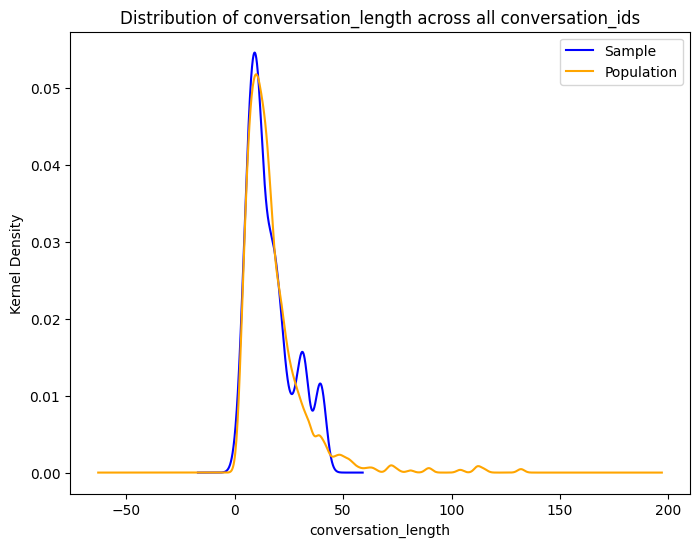

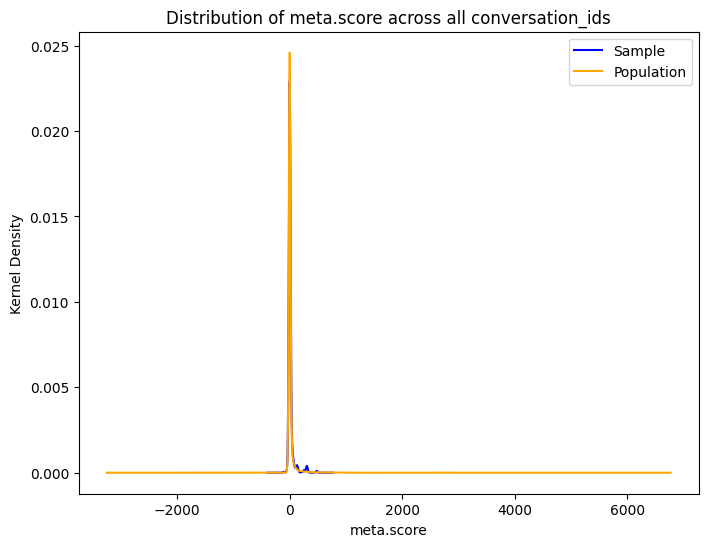

In [28]:
validate_samples(awry_sample,df_awry,["conversation_length", "meta.score"], "CONV_ID")

Length of the sample df 629
Number of unique conversations 100
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


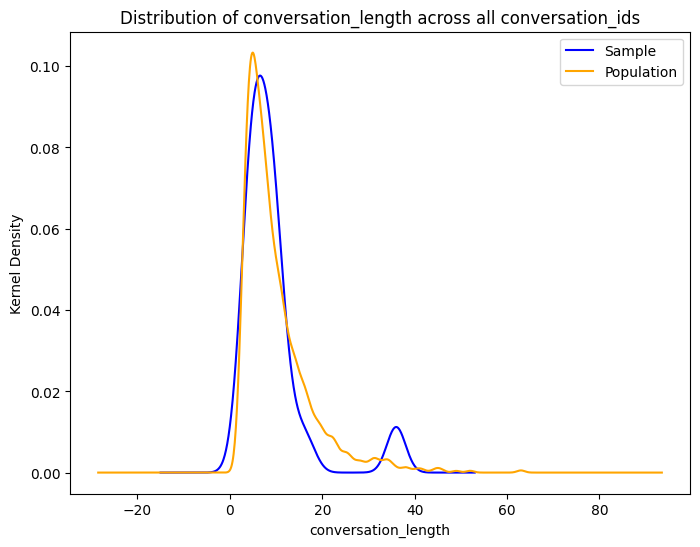

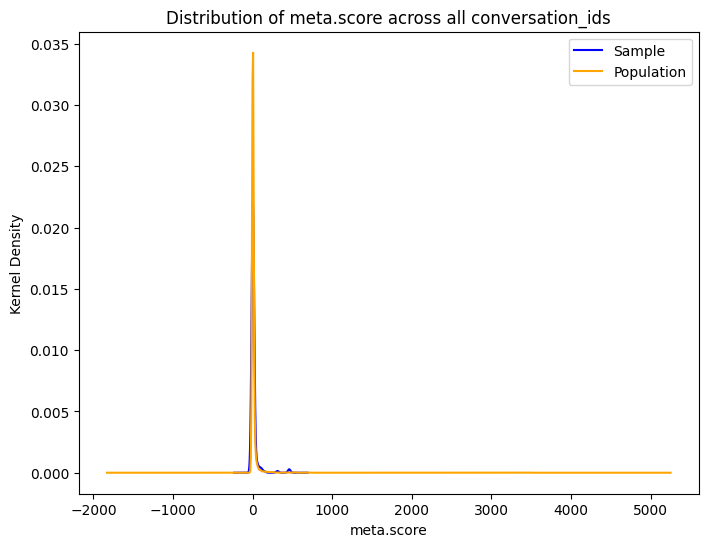

In [29]:
validate_samples(winning_sample,df_winning_conversations,["conversation_length", "meta.score"], "CONV_ID")